In [2]:
import os
os.chdir('../')
os.getcwd()

'e:\\github_clone\\gridGPT'

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import torch.optim as optim
import grid2op
from src.utils.converter import ActionConverter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ActorCritic(nn.Module):
    def __init__(self):
        super().__init__()
        self.affine = nn.Sequential(
            nn.Linear(493, 512), nn.ReLU(),
            nn.Linear(512, 1024), nn.ReLU(),
            nn.Linear(1024, 512), nn.ReLU(),
            nn.Linear(512, 256),
            nn.LayerNorm(256),                 # ← normalize hidden to tame scales
            nn.ReLU(),
        )
        self.action_layer = nn.Linear(256, 178)
        self.value_layer  = nn.Linear(256, 1)

        self.logprobs, self.state_values, self.rewards = [], [], []

        # Optional: safer initializations
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=0.0, nonlinearity='relu')
                nn.init.zeros_(m.bias)

    @torch.no_grad()
    def _sanitize(self, x):
        x = torch.nan_to_num(x, nan=0.0, posinf=1e6, neginf=-1e6)
        x.clamp_(-1e6, 1e6)
        return x

    def forward(self, state_np):
        x = torch.from_numpy(state_np).float().to(self.value_layer.weight.device)
        x = self._sanitize(x)

        h = self.affine(x)                       # includes LayerNorm + ReLU
        h = torch.nan_to_num(h)                  # belt & suspenders

        logits = self.action_layer(h)
        logits = torch.nan_to_num(logits)        # if any NaN slipped through
        logits = logits - logits.max()           # stable softmax
        probs  = torch.softmax(logits, dim=-1)

        # final guard
        if not torch.isfinite(probs).all():
            # Zero-out non-finites and renormalize as an emergency fallback
            probs = torch.where(torch.isfinite(probs), probs, torch.zeros_like(probs))
            s = probs.sum()
            probs = (probs + 1e-12) / (s + 1e-12)

        dist   = Categorical(probs=probs)
        action = dist.sample()

        self.logprobs.append(dist.log_prob(action))
        self.state_values.append(self.value_layer(h).squeeze(-1))

        return action.item()

    
    def calculateLoss(self, gamma=0.99, value_coef=0.5, entropy_coef=0.01):
        # discounted returns
        returns = []
        g = 0.0
        for r in reversed(self.rewards):
            g = r + gamma * g
            returns.insert(0, g)
        returns = torch.tensor(returns, dtype=torch.float32, device=device)
    
        # stabilize return normalization
        returns = (returns - returns.mean()) / (returns.std(unbiased=False) + 1e-8)
    
        values = torch.stack(self.state_values).to(device).squeeze(-1)
        logprobs = torch.stack(self.logprobs).to(device)
    
        advantages = returns - values.detach()
        # advantage normalization helps a LOT with small/medium LR
        advantages = (advantages - advantages.mean()) / (advantages.std(unbiased=False) + 1e-8)
    
        policy_loss = -(logprobs * advantages).mean()
        value_loss  = F.smooth_l1_loss(values, returns)
    
        # crude entropy from logprobs; better is dist.entropy() if you also stored dist params
        entropy = -(logprobs.exp() * logprobs).mean()
    
        return policy_loss + value_coef * value_loss - entropy_coef * entropy

    
    def clearMemory(self):
        del self.logprobs[:]
        del self.state_values[:]
        del self.rewards[:]

    def save_checkpoint(self, optimizer:optim=None, filename="actor_critic_checkpoint.pth"):
        """Save model + optimizer for exact training resumption."""
        os.makedirs("models", exist_ok=True)
        checkpoint = {
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }
        save_path = os.path.join("models", filename)
        torch.save(checkpoint, save_path)
        print(f"[SAVE] Checkpoint saved to {save_path}")


    def load_checkpoint(self, folder_name=None, filename="actor_critic_checkpoint.pth", optimizer:optim=None, load_optimizer=True):
        """Load model + optimizer state."""
        if folder_name is not None:
            file_path = os.path.join(folder_name, filename)
        else:
            file_path = os.path.join("models", filename)
        if not os.path.exists(file_path):
            print(f"[LOAD] No checkpoint found at {file_path}")
            return False

        checkpoint = torch.load(file_path, map_location=device)
        self.load_state_dict(checkpoint['model_state_dict'])
        if load_optimizer and 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"[LOAD] Checkpoint loaded from {file_path}")
        return True


In [5]:
import grid2op
from lightsim2grid import LightSimBackend
from grid2op.Reward import L2RPNSandBoxScore
env = grid2op.make("l2rpn_case14_sandbox",
                  backend=LightSimBackend(), 
                  reward_class=L2RPNSandBoxScore,
                #other_rewards={"loss": LossReward, "margin": MarginReward}
               )
converter = ActionConverter(env)

In [6]:
import torch.optim as optim
from pathlib import Path
import csv
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def train():
    # Defaults parameters:
    #    gamma = 0.99
    #    lr = 0.02
    #    betas = (0.9, 0.999)
    #    random_seed = 543

    survival_steps = []
    episode_rewards = []


    render = False
    gamma = 0.99
    lr = 1e-4
    betas = (0.9, 0.999)
    random_seed = 543
    
    torch.manual_seed(random_seed)
    
    policy = ActorCritic().to(device=device)
    optimizer = optim.Adam(policy.parameters(), lr=lr, betas=betas)
    print(lr,betas)
    
    running_reward = 0
    for i_episode in range(0, 10000):
        ep_reward = 0.0
        steps = 0
        state = env.reset()

        for t in range(10000):
            action = policy(state.to_vect())
            env_action = converter.act(action)
            state, reward, done, _ = env.step(env_action)

            ep_reward += reward
            steps += 1
            
            policy.rewards.append(reward)
            running_reward += reward
            if done:
                survival_steps.append(t)
                break

            
                    
        # Updating the policy :
        optimizer.zero_grad()
        loss = policy.calculateLoss(gamma)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.0)
        if all(torch.isfinite(p.grad).all() for p in policy.parameters() if p.grad is not None):
            optimizer.step()
        else:
            print("[WARN] Non-finite grad; skipped optimizer.step()")
        policy.clearMemory()
        
        episode_rewards.append(ep_reward)
        # saving the model if episodes > 999 OR avg reward > 200 
        if i_episode % 500 == 0:
            policy.save_checkpoint(optimizer, filename=f"actor_critic_episode_{i_episode}.pth")
            
        
        
        if i_episode % 10 == 0:
            running_reward = running_reward/20
            print('Episode {}\tlength: {}\treward: {}'.format(i_episode, t, running_reward))
            running_reward = 0
    
    reward_dir = "training_logs"
    os.makedirs(reward_dir, exist_ok=True)
    np.save(os.path.join(reward_dir, "episode_rewards.npy"), np.array(episode_rewards))
    np.save(os.path.join(reward_dir, "survival_steps.npy"), np.array(survival_steps))
            
if __name__ == '__main__':
    train()

0.02 (0.9, 0.999)
[SAVE] Checkpoint saved to models\actor_critic_episode_0.pth
Episode 0	length: 1	reward: 1.308377742767334
Episode 10	length: 665	reward: 1588.924431180954


KeyboardInterrupt: 

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def _nan_guard(a):
    """Replace inf with nan, then forward/back fill nans to keep plots continuous."""
    a = np.asarray(a, dtype=float)
    a[~np.isfinite(a)] = np.nan
    if np.all(np.isnan(a)):
        return np.zeros_like(a)
    # forward-fill then back-fill
    idx = np.where(~np.isnan(a), np.arange(a.size), 0)
    np.maximum.accumulate(idx, out=idx)
    out = a[idx]
    # back-fill any leading nans
    if np.isnan(out[0]):
        first_valid = np.argmax(~np.isnan(a))
        out[:first_valid] = a[first_valid]
    return out

def _moving_average(y, window=100):
    """Centered moving average with edge handling (reflect pad)."""
    y = np.asarray(y, dtype=float)
    if window <= 1 or window > len(y):
        return y
    pad = window // 2
    y_pad = np.pad(y, (pad, pad-((window+1) % 2)), mode='reflect')
    kernel = np.ones(window) / window
    sm = np.convolve(y_pad, kernel, mode='valid')
    # Make length match y exactly
    return sm[:len(y)]

def plot_rewards(
    rewards,
    smooth_window=100,
    show=True,
    savepath=None,
    title="Episode Rewards"
):
    """
    Plot raw per-episode rewards and a smoothed curve (moving average).

    Args:
        rewards (array-like): reward per episode (len = #episodes)
        smooth_window (int): window size for moving average (>=2 to smooth)
        show (bool): plt.show() if True
        savepath (str|None): if provided, saves the figure to this path
        title (str): plot title
    """
    r = _nan_guard(rewards)
    sm = _moving_average(r, window=max(2, int(smooth_window))) if smooth_window and smooth_window > 1 else r

    episodes = np.arange(1, len(r) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(episodes, r, linewidth=1, alpha=0.35, label="Reward (raw)")
    if smooth_window and smooth_window > 1:
        plt.plot(episodes, sm, linewidth=2.0, label=f"Reward (MA, w={smooth_window})")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title(title)
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=150, bbox_inches="tight")
    if show:
        plt.show()

def plot_survival_steps(
    survival_steps,
    show=True,
    savepath=None,
    title="Survival Steps per Episode"
):
    """
    Plot survival steps with Episode on X-axis and Steps on Y-axis.

    Args:
        survival_steps (array-like): steps survived per episode
        show (bool): plt.show() if True
        savepath (str|None): if provided, saves the figure to this path
        title (str): plot title
    """
    s = _nan_guard(survival_steps)
    episodes = np.arange(1, len(s) + 1)

    plt.figure(figsize=(10, 5))
    # Line plot; scatter overlay helps when there are many episodes
    plt.plot(episodes, s, linewidth=1.0, alpha=0.8, label="Survival steps")
    # Optional: light scatter to reveal density (comment out if you don’t want it)
    plt.scatter(episodes, s, s=6, alpha=0.3)
    plt.xlabel("Episode")
    plt.ylabel("Steps Survived")
    plt.title(title)
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=150, bbox_inches="tight")
    if show:
        plt.show()


In [8]:
rewards = np.load("training_logs\\episode_rewards.npy")
survival = np.load("training_logs\\survival_steps.npy")


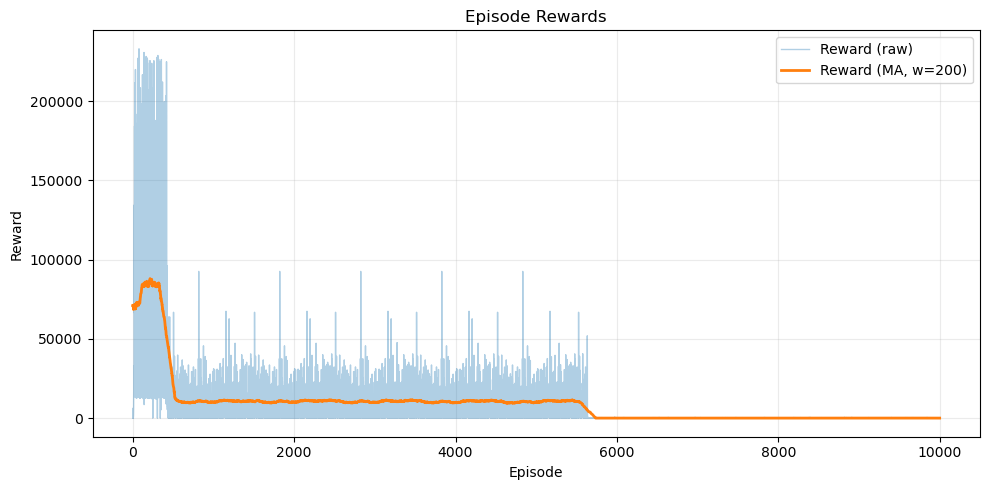

In [9]:
plot_rewards(rewards, smooth_window=200)

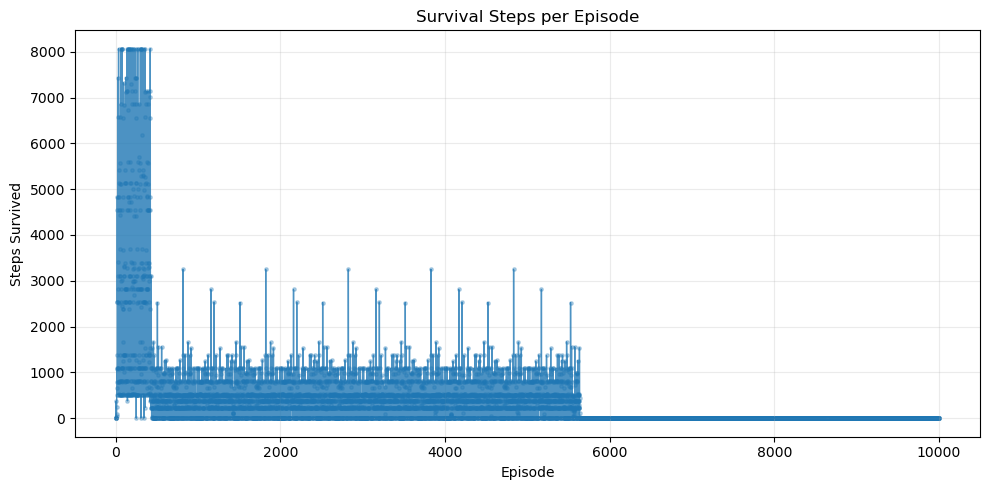

In [10]:
plot_survival_steps(survival)